In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import SMOTE
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os

## Load and Preprocess the Data

In [5]:
df = pd.read_csv('breast-level_annotations.csv')

df.head()

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,d8125545210c08e1b1793a5af6458ee2,L,CC,3518,2800,BI-RADS 2,DENSITY C,training
1,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,290c658f4e75a3f83ec78a847414297c,L,MLO,3518,2800,BI-RADS 2,DENSITY C,training
2,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,cd0fc7bc53ac632a11643ac4cc91002a,R,CC,3518,2800,BI-RADS 2,DENSITY C,training
3,b8d273e8601f348d3664778dae0e7e0b,b36517b9cbbcfd286a7ae04f643af97a,71638b1e853799f227492bfb08a01491,R,MLO,3518,2800,BI-RADS 2,DENSITY C,training
4,8269f5971eaca3e5d3772d1796e6bd7a,d931832a0815df082c085b6e09d20aac,dd9ce3288c0773e006a294188aadba8e,L,CC,3518,2800,BI-RADS 1,DENSITY C,training


In [8]:
df['birads_numeric'] = df['breast_birads'].str.extract(r'(\d+)').astype(int)

df['class'] = df['birads_numeric'].apply(lambda x: 0 if x == 1 else 1)

df['class'].value_counts()

class
0    13406
1     6594
Name: count, dtype: int64

In [10]:
from sklearn.utils import shuffle
train_df = df[df['split'] == 'training'].sample(frac=0.7, random_state=50).reset_index(drop=True)
test_df = df[df['split'] == 'test'].sample(frac=0.7, random_state=50).reset_index(drop=True)
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")


Training set size: 11200
Test set size: 2800


## Load and Preprocess Images

In [13]:
BASE_DIR = r"C:\Users\kuday\Downloads\images"  

def load_image(image_path):
   
    try:
        img = Image.open(image_path).convert('L')  
        img = img.resize((256, 256)) 
        img = ImageOps.equalize(img)  

        return np.array(img, dtype=np.float16) / 255.0 
    except Exception as e:
        print(f"Ошибка при загрузке {image_path}: {e}")
        return None  


In [15]:
X_train, y_train = [], []

for _, row in train_df.iterrows():
    image_path = os.path.join(BASE_DIR, row['study_id'], f"{row['image_id']}.jpg")
    img = load_image(image_path)
    if img is not None:
        X_train.append(img)
        y_train.append(row['class'])


X_test, y_test = [], []

for _, row in test_df.iterrows():
    image_path = os.path.join(BASE_DIR, row['study_id'], f"{row['image_id']}.jpg")
    img = load_image(image_path)
    if img is not None:
        X_test.append(img)
        y_test.append(row['class'])


X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


In [16]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [17]:
pca = PCA(n_components=100, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [23]:
from collections import Counter
print("Before SMOTE:", Counter(y_train))

Before SMOTE: Counter({0: 7566, 1: 3634})


In [27]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE:", Counter(y_train))

After SMOTE: Counter({0: 7566, 1: 7566})


## Implement and Evaluate Models

In [32]:
def evaluate_model(model, X_train, X_test, y_train, y_test, threshold=0.2):
    model.fit(X_train, y_train)  
    y_probs = model.predict_proba(X_test)[:, 1]  
    y_pred = (y_probs > threshold).astype(int)  
    y_pred = model.predict(X_test)
    
   
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    
  
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    
   
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

<strong style="font-size:16px;">Logistic Regression</strong>


Logistic Regression:
Accuracy: 0.5146
Precision: 0.3274
Recall: 0.4601
F1-Score: 0.3826
ROC-AUC: 0.5006


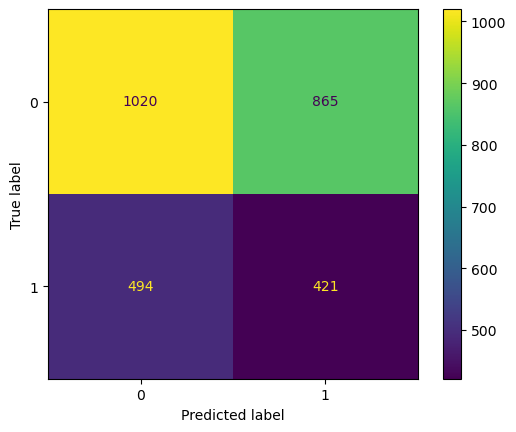

In [34]:
print("Logistic Regression:")
lr = LogisticRegression(penalty='l1', solver='saga', C=50)
evaluate_model(lr, X_train, X_test, y_train, y_test)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

<strong style="font-size:16px;">Logistic Regression With Grid Search</strong>


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform  

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'penalty': ['l1', 'l2'],           
    'solver': ['liblinear', 'saga'],    
    'max_iter': [100, 500, 1000]         
}

lr = LogisticRegression()

grid_search = GridSearchCV(
    estimator=lr,             
    param_grid=param_grid,    
    scoring='recall',          
    cv=5,                      
    n_jobs=-1,                
    verbose=1                  
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Recall: 0.5592


<strong style="font-size:16px;">SVM</strong>


Support Vector Machine:
Accuracy: 0.5571
Precision: 0.3415
Recall: 0.3825
F1-Score: 0.3608
ROC-AUC: 0.5122


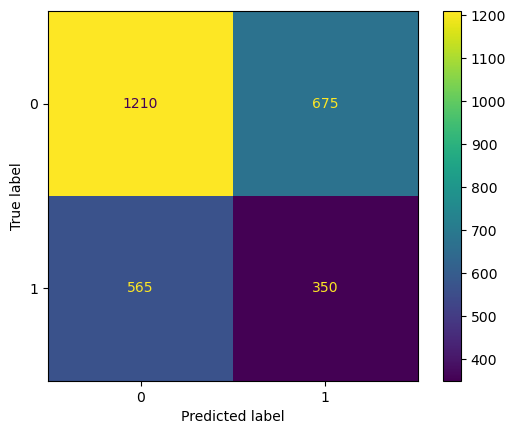

In [54]:
print("Support Vector Machine:")
svm = SVC(probability=True)
evaluate_model(svm, X_train, X_test, y_train, y_test)

<strong style="font-size:16px;">SVM With Grid Search</strong>


In [21]:
param_grid = {
    'C': [0.1, 1],                 
    'kernel': ['linear', 'rbf', 'poly'], 
    'degree': [2, 3],      
    'class_weight': ['balanced']       
}
svm = SVC(probability=True, random_state=42)

grid_search = GridSearchCV(
    estimator=svm, 
    param_grid=param_grid,
    scoring='recall',  
    cv=5,              
    n_jobs=-1,         
    verbose=1        
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'degree': 2, 'kernel': 'rbf'}
Best Recall: 0.4733


<strong style="font-size:16px;">Decision Tree</strong>


Decision Tree:
Accuracy: 0.5346
Precision: 0.3249
Recall: 0.3934
F1-Score: 0.3559
ROC-AUC: 0.4983


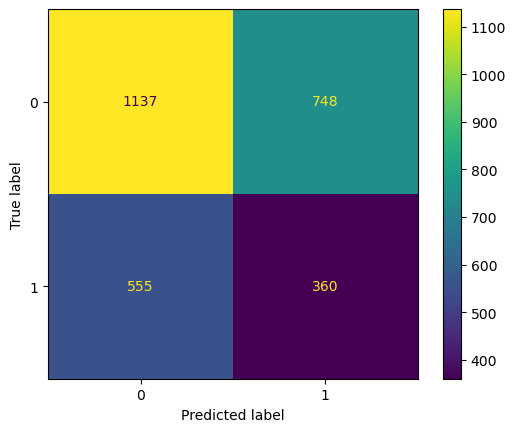

In [40]:
print("Decision Tree:")
dt = DecisionTreeClassifier()
evaluate_model(dt, X_train, X_test, y_train, y_test)

<strong style="font-size:16px;">Decision Tree With Grid Search</strong>


In [42]:
param_grid = {
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],   
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']  
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(
    estimator=dt,              
    param_grid=param_grid,     
    scoring='recall',          
    cv=5,                     
    n_jobs=-1,                
    verbose=1               
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Recall: 0.7444


<strong style="font-size:16px;">Random Forest</strong>

Random Forest:
Accuracy: 0.5811
Precision: 0.3489
Recall: 0.3257
F1-Score: 0.3369
ROC-AUC: 0.5154


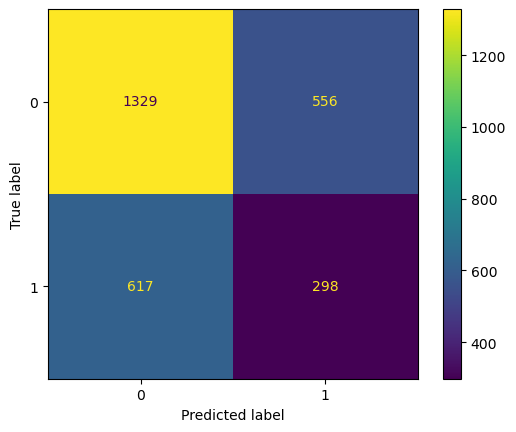

In [52]:
print("Random Forest:")
rf = RandomForestClassifier()
evaluate_model(rf, X_train, X_test, y_train, y_test)

<strong style="font-size:16px;">Random Forest With Grid Search</strong>


In [46]:
param_grid = {
    'n_estimators': [50, 100, 200],     
    'max_depth': [None, 10, 20],   
    'min_samples_split': [2, 5],    
    'min_samples_leaf': [1, 2],     
    'criterion': ['gini', 'entropy'],   
    'max_features': ['sqrt', 'log2']  
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,              
    param_grid=param_grid,     
    scoring='recall',          
    cv=5,                      
    n_jobs=-1,                 
    verbose=1                  
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Recall: 0.8155


<strong style="font-size:16px;">KNN</strong>


k-Nearest Neighbors:
Accuracy: 0.5114
Precision: 0.3392
Recall: 0.5224
F1-Score: 0.4114
ROC-AUC: 0.5143


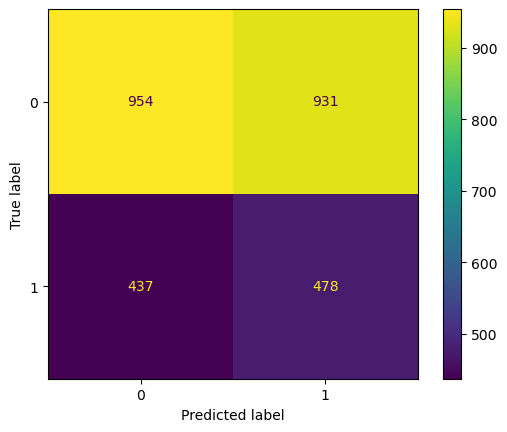

In [48]:
print("k-Nearest Neighbors:")
knn = KNeighborsClassifier()
evaluate_model(knn, X_train, X_test, y_train, y_test)

<strong style="font-size:16px;">KNN With Grid Search</strong>


In [50]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],   
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=knn,            
    param_grid=param_grid,    
    scoring='recall',          
    cv=5,                     
    n_jobs=-1,                
    verbose=1                 
)

grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Recall: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Best Recall: 0.9030
